## DRAGON *DualFinder*: An Instance of the DRAGON CNN Architecture Specialized for Dual AGN Detection.
### Authors: Isaac Moskowitz and Jeremy Ng
### Collaborators: C. Meg Urry (PI), Aritra Ghosh. 
#### Began June 7, 2024


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import torch.nn as nn
import logging
import pandas as pd
import csv
import sys
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import cross_val_score 
from keras import backend as K
import os
from os.path import exists
from tqdm import tqdm
import glob
#import tensorflow_addons as tfa
import shutil
#from dual_finder import DualFinder, loadModelClass
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")
print(tf.config.list_physical_devices())
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
from astropy.io import fits

sys.path.append("DRAGON_Dual_Finder/dual_finder/cnn/")
sys.path.append("DRAGON_Dual_Finder/dual_finder/optimize/")
sys.path.append("DRAGON_Dual_Finder/dual_finder/preprocess_data/")
sys.path.append("DRAGON_Dual_Finder/dual_finder/visualize/")
from create_cnn import ModelCreator
from load_model import loadModelClass
from train_cnn import DualFinder
from extract_feature_maps import FeatureExtractor
from fits_utils import plot_dataset_sample
from process_data import make_datasets_other_bands, create_dataset, crop_center
from optimize_hyperparameters import OptimizeHyperparameters
from visualize_performance import load_training_history, plot_training_progress, plot_grouped_training_progress, VisualizeOptimization
from inference_tests import testResults

2024-06-25 21:24:33.232349: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-25 21:24:33.277780: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-25 21:24:33.277820: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-25 21:24:33.277841: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-25 21:24:33.286678: I tensorflow/core/platform/cpu_feature_g

GPU is available
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16140044550834759267
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10086383616
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16180900014463106205
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3b:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


2024-06-25 21:24:38.815512: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 9619 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3b:00.0, compute capability: 7.5


In [2]:
#os.chdir("~/")
#!pwd
empty_sky_filepath = "data_preprocessing/training_datasets/empty_space_dataset/empty_space_train_data/"
single_AGN_filepath = "data_preprocessing/training_datasets/single_AGN_datasets/confirmed_single_AGN/"
dual_AGN_filepath = "data_preprocessing/training_datasets/dual_AGN_datasets/train_data/"
offset_AGN_filepath = 'data_preprocessing/training_datasets/offset_AGN_datasets/train_data/'
stellar_filepath = "data_preprocessing/training_datasets/stellar_dataset/train_data/"
merger_filepath = "data_preprocessing/training_datasets/merger_datasets/new_train_data/g_band_mergers/"
train_data_labels, val_data_labels, test_data_labels = create_dataset(empty_sky_filepath = empty_sky_filepath,
                                                                      dual_image_filepath = dual_AGN_filepath,
                                                                      merger_filepath = merger_filepath,
                                                                      single_image_filepath = single_AGN_filepath)
train_dataset, train_labels, train_filepaths = train_data_labels
val_dataset, val_labels, val_filepaths = val_data_labels
test_dataset, test_labels, test_filepaths = test_data_labels


2024-06-25 21:24:40,050 - INFO - Loading images from data_preprocessing/training_datasets/empty_space_dataset/empty_space_train_data/ with label empty_sky...
100%|██████████| 9336/9336 [00:15<00:00, 614.91it/s]
0it [00:00, ?it/s]2024-06-25 21:24:55.483639: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9619 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3b:00.0, compute capability: 7.5
9336it [00:53, 175.51it/s]
2024-06-25 21:25:50,430 - INFO - Loading images from data_preprocessing/training_datasets/single_AGN_datasets/confirmed_single_AGN/ with label single_AGN...


Loaded 37344 images with 37344 labels from data_preprocessing/training_datasets/empty_space_dataset/empty_space_train_data/


100%|██████████| 2958/2958 [00:04<00:00, 622.87it/s]
2958it [00:56, 52.70it/s]
2024-06-25 21:26:52,871 - INFO - Loading images from data_preprocessing/training_datasets/dual_AGN_datasets/train_data/ with label dual_AGN...


Loaded 32538 images with 32538 labels from data_preprocessing/training_datasets/single_AGN_datasets/confirmed_single_AGN/
Length of single AGN images: 32538


 13%|█▎        | 7523/55921 [00:09<00:57, 841.58it/s]WARNING: File may have been truncated: actual file length (38224) is smaller than the expected size (40320) [astropy.io.fits.file]
2024-06-25 21:27:02,226 - WARNING - File may have been truncated: actual file length (38224) is smaller than the expected size (40320)
100%|██████████| 55921/55921 [01:08<00:00, 821.48it/s]
2024-06-25 21:28:01,835 - INFO - expanding dims
2024-06-25 21:28:01,835 - INFO - Loading images from data_preprocessing/training_datasets/merger_datasets/new_train_data/g_band_mergers/ with label merger...


Loaded 55921 images with 55921 labels from data_preprocessing/training_datasets/dual_AGN_datasets/train_data/


100%|██████████| 11009/11009 [00:18<00:00, 600.54it/s]
11009it [01:24, 129.53it/s]


Loaded 55045 images with 55045 labels from data_preprocessing/training_datasets/merger_datasets/new_train_data/g_band_mergers/
Length of merger imagesL: (55045, 94, 94, 1)
Total images: (180848, 94, 94, 1)
Total labels: (180848,)
Total filepaths: (180848,)
Train_dataset: (117551, 94, 94, 1)
Train_labels: (117551,)
Train_filepaths: (117551,)
Val_dataset: (36169, 94, 94, 1)
Val_labels: (36169,)
Val_filepaths: (36169,)
Test_dataset: (27128, 94, 94, 1)
Test_labels: (27128,)
Test_filepaths: (27128,)


In [ ]:
print(np.shape(val_dataset))
print(np.shape(val_labels))

In [3]:
image_shape = (94,94,1)
epoch = 25
batch_size = 64
init_learning_rate = 5e-5
num_classes = 4
model_type = 'dualfinder'
importance_score = [1.0, 1.0]

dual_finder_instance = DualFinder(train_dataset, val_dataset, image_shape, train_labels, val_labels, epoch, batch_size, init_learning_rate, num_classes, model_type, importance_score, display_architecture = True)
history, dual_finder_model = dual_finder_instance.trainCNN(model_filepath = "../combined_model_test_2/", dropout_rate = 0.5, save_feature_maps = False)

['single_AGN' 'merger' 'merger' ... 'single_AGN' 'empty_sky' 'empty_sky']
['dual_AGN' 'single_AGN' 'dual_AGN' ... 'dual_AGN' 'dual_AGN' 'merger']
Converting to list
Converting to list
train_labels shape: (117551, 4)
val_labels shape: (36169, 4)
Unique train labels: [0. 1.]
Unique val labels: [0. 1.]
4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 94, 94, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 94, 94, 64)        640       
                                                                 
 dropout (Dropout)           (None, 94, 94, 64)        0         
                                                                 
 batch_normalization (Batch  (None, 94, 94, 64)        256       
 Normalization)                                                  
                 

2024-06-25 21:29:54,480 - INFO - 'save_feature_maps' == False, NOT saving feature maps


train_images shape: (117551, 94, 94, 1)
train_labels shape: (117551, 4)
val_images shape: (36169, 94, 94, 1)
val_labels shape: (36169, 4)
Epoch 1/25


2024-06-25 21:30:01.199501: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-06-25 21:30:01.533126: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-06-25 21:30:03.409767: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1550101bdd60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-25 21:30:03.409803: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-06-25 21:30:03.414914: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-25 21:30:03.509117: I ./tensorflow/compiler/jit/device_compiler.h:186] C

3674/3674 [==============================] - ETA: 0s - loss: 14.2141 - accuracy: 0.8914 - precision: 0.8999 - recall: 0.8833 - f1_score: 0.8886INFO:tensorflow:Assets written to: ../combined_model_test_2/_checkpoint_training/assets


2024-06-25 21:33:34,023 - INFO - Assets written to: ../combined_model_test_2/_checkpoint_training/assets


3674/3674 [==============================] - 215s 57ms/step - loss: 14.2141 - accuracy: 0.8914 - precision: 0.8999 - recall: 0.8833 - f1_score: 0.8886 - val_loss: 5.4613 - val_accuracy: 0.8710 - val_precision: 0.8746 - val_recall: 0.8674 - val_f1_score: 0.8704
Epoch 2/25
3673/3674 [============================>.] - ETA: 0s - loss: 2.9536 - accuracy: 0.9322 - precision: 0.9344 - recall: 0.9303 - f1_score: 0.9305INFO:tensorflow:Assets written to: ../combined_model_test_2/_checkpoint_training/assets


2024-06-25 21:37:00,574 - INFO - Assets written to: ../combined_model_test_2/_checkpoint_training/assets


3674/3674 [==============================] - 207s 56ms/step - loss: 2.9534 - accuracy: 0.9322 - precision: 0.9344 - recall: 0.9303 - f1_score: 0.9305 - val_loss: 1.7485 - val_accuracy: 0.8466 - val_precision: 0.8633 - val_recall: 0.8204 - val_f1_score: 0.8270
Epoch 3/25
3673/3674 [============================>.] - ETA: 0s - loss: 1.0547 - accuracy: 0.9431 - precision: 0.9451 - recall: 0.9416 - f1_score: 0.9418INFO:tensorflow:Assets written to: ../combined_model_test_2/_checkpoint_training/assets


2024-06-25 21:40:26,701 - INFO - Assets written to: ../combined_model_test_2/_checkpoint_training/assets


3674/3674 [==============================] - 206s 56ms/step - loss: 1.0546 - accuracy: 0.9431 - precision: 0.9451 - recall: 0.9416 - f1_score: 0.9418 - val_loss: 1.3583 - val_accuracy: 0.7786 - val_precision: 0.7818 - val_recall: 0.7754 - val_f1_score: 0.7812
Epoch 4/25
3673/3674 [============================>.] - ETA: 0s - loss: 0.6114 - accuracy: 0.9486 - precision: 0.9505 - recall: 0.9470 - f1_score: 0.9474INFO:tensorflow:Assets written to: ../combined_model_test_2/_checkpoint_training/assets


2024-06-25 21:43:53,634 - INFO - Assets written to: ../combined_model_test_2/_checkpoint_training/assets


3674/3674 [==============================] - 207s 56ms/step - loss: 0.6113 - accuracy: 0.9486 - precision: 0.9505 - recall: 0.9471 - f1_score: 0.9474 - val_loss: 0.5405 - val_accuracy: 0.9499 - val_precision: 0.9508 - val_recall: 0.9496 - val_f1_score: 0.9481
Epoch 5/25
3673/3674 [============================>.] - ETA: 0s - loss: 0.4701 - accuracy: 0.9534 - precision: 0.9552 - recall: 0.9516 - f1_score: 0.9522INFO:tensorflow:Assets written to: ../combined_model_test_2/_checkpoint_training/assets


2024-06-25 21:47:20,176 - INFO - Assets written to: ../combined_model_test_2/_checkpoint_training/assets


3674/3674 [==============================] - 207s 56ms/step - loss: 0.4701 - accuracy: 0.9534 - precision: 0.9552 - recall: 0.9517 - f1_score: 0.9523 - val_loss: 0.4394 - val_accuracy: 0.9569 - val_precision: 0.9585 - val_recall: 0.9549 - val_f1_score: 0.9555
Epoch 6/25
3673/3674 [============================>.] - ETA: 0s - loss: 0.3988 - accuracy: 0.9559 - precision: 0.9580 - recall: 0.9541 - f1_score: 0.9548INFO:tensorflow:Assets written to: ../combined_model_test_2/_checkpoint_training/assets


2024-06-25 21:50:46,586 - INFO - Assets written to: ../combined_model_test_2/_checkpoint_training/assets


3674/3674 [==============================] - 206s 56ms/step - loss: 0.3988 - accuracy: 0.9560 - precision: 0.9580 - recall: 0.9541 - f1_score: 0.9548 - val_loss: 0.4536 - val_accuracy: 0.9362 - val_precision: 0.9407 - val_recall: 0.9331 - val_f1_score: 0.9354
Epoch 7/25
3673/3674 [============================>.] - ETA: 0s - loss: 0.3554 - accuracy: 0.9586 - precision: 0.9606 - recall: 0.9568 - f1_score: 0.9576INFO:tensorflow:Assets written to: ../combined_model_test_2/_checkpoint_training/assets


2024-06-25 21:54:12,508 - INFO - Assets written to: ../combined_model_test_2/_checkpoint_training/assets


3674/3674 [==============================] - 206s 56ms/step - loss: 0.3554 - accuracy: 0.9586 - precision: 0.9606 - recall: 0.9568 - f1_score: 0.9576 - val_loss: 0.3450 - val_accuracy: 0.9628 - val_precision: 0.9645 - val_recall: 0.9614 - val_f1_score: 0.9615
Epoch 8/25
3673/3674 [============================>.] - ETA: 0s - loss: 0.3180 - accuracy: 0.9599 - precision: 0.9618 - recall: 0.9583 - f1_score: 0.9588INFO:tensorflow:Assets written to: ../combined_model_test_2/_checkpoint_training/assets


2024-06-25 21:57:38,938 - INFO - Assets written to: ../combined_model_test_2/_checkpoint_training/assets


3674/3674 [==============================] - 206s 56ms/step - loss: 0.3180 - accuracy: 0.9599 - precision: 0.9618 - recall: 0.9583 - f1_score: 0.9588 - val_loss: 0.3467 - val_accuracy: 0.9472 - val_precision: 0.9490 - val_recall: 0.9463 - val_f1_score: 0.9462
Epoch 9/25
3673/3674 [============================>.] - ETA: 0s - loss: 0.2996 - accuracy: 0.9605 - precision: 0.9625 - recall: 0.9586 - f1_score: 0.9595INFO:tensorflow:Assets written to: ../combined_model_test_2/_checkpoint_training/assets


2024-06-25 22:01:04,696 - INFO - Assets written to: ../combined_model_test_2/_checkpoint_training/assets


3674/3674 [==============================] - 206s 56ms/step - loss: 0.2996 - accuracy: 0.9605 - precision: 0.9625 - recall: 0.9586 - f1_score: 0.9595 - val_loss: 0.6129 - val_accuracy: 0.7782 - val_precision: 0.9363 - val_recall: 0.7715 - val_f1_score: 0.6695
Epoch 10/25
3673/3674 [============================>.] - ETA: 0s - loss: 0.2777 - accuracy: 0.9628 - precision: 0.9646 - recall: 0.9612 - f1_score: 0.9617INFO:tensorflow:Assets written to: ../combined_model_test_2/_checkpoint_training/assets


2024-06-25 22:04:30,888 - INFO - Assets written to: ../combined_model_test_2/_checkpoint_training/assets


3674/3674 [==============================] - 206s 56ms/step - loss: 0.2777 - accuracy: 0.9628 - precision: 0.9646 - recall: 0.9612 - f1_score: 0.9617 - val_loss: 0.3092 - val_accuracy: 0.9482 - val_precision: 0.9493 - val_recall: 0.9465 - val_f1_score: 0.9470
Epoch 11/25
3673/3674 [============================>.] - ETA: 0s - loss: 0.2671 - accuracy: 0.9624 - precision: 0.9643 - recall: 0.9609 - f1_score: 0.9614INFO:tensorflow:Assets written to: ../combined_model_test_2/_checkpoint_training/assets


2024-06-25 22:07:57,436 - INFO - Assets written to: ../combined_model_test_2/_checkpoint_training/assets


3674/3674 [==============================] - 207s 56ms/step - loss: 0.2671 - accuracy: 0.9624 - precision: 0.9643 - recall: 0.9609 - f1_score: 0.9614 - val_loss: 0.5195 - val_accuracy: 0.8862 - val_precision: 0.9126 - val_recall: 0.7269 - val_f1_score: 0.8741
Epoch 12/25
3673/3674 [============================>.] - ETA: 0s - loss: 0.2588 - accuracy: 0.9637 - precision: 0.9655 - recall: 0.9620 - f1_score: 0.9627INFO:tensorflow:Assets written to: ../combined_model_test_2/_checkpoint_training/assets


2024-06-25 22:11:24,271 - INFO - Assets written to: ../combined_model_test_2/_checkpoint_training/assets


3674/3674 [==============================] - 207s 56ms/step - loss: 0.2588 - accuracy: 0.9637 - precision: 0.9655 - recall: 0.9620 - f1_score: 0.9627 - val_loss: 0.3798 - val_accuracy: 0.9282 - val_precision: 0.9295 - val_recall: 0.9269 - val_f1_score: 0.9270
Epoch 13/25
3673/3674 [============================>.] - ETA: 0s - loss: 0.2429 - accuracy: 0.9649 - precision: 0.9667 - recall: 0.9635 - f1_score: 0.9639INFO:tensorflow:Assets written to: ../combined_model_test_2/_checkpoint_training/assets


2024-06-25 22:14:50,751 - INFO - Assets written to: ../combined_model_test_2/_checkpoint_training/assets


3674/3674 [==============================] - 206s 56ms/step - loss: 0.2429 - accuracy: 0.9649 - precision: 0.9667 - recall: 0.9635 - f1_score: 0.9639 - val_loss: 0.2242 - val_accuracy: 0.9705 - val_precision: 0.9728 - val_recall: 0.9689 - val_f1_score: 0.9700
Epoch 14/25
3673/3674 [============================>.] - ETA: 0s - loss: 0.2372 - accuracy: 0.9654 - precision: 0.9671 - recall: 0.9638 - f1_score: 0.9644INFO:tensorflow:Assets written to: ../combined_model_test_2/_checkpoint_training/assets


2024-06-25 22:18:17,580 - INFO - Assets written to: ../combined_model_test_2/_checkpoint_training/assets


3674/3674 [==============================] - 207s 56ms/step - loss: 0.2372 - accuracy: 0.9654 - precision: 0.9671 - recall: 0.9638 - f1_score: 0.9644 - val_loss: 0.4633 - val_accuracy: 0.8823 - val_precision: 0.9550 - val_recall: 0.7727 - val_f1_score: 0.8683
Epoch 15/25
3673/3674 [============================>.] - ETA: 0s - loss: 0.2316 - accuracy: 0.9653 - precision: 0.9671 - recall: 0.9638 - f1_score: 0.9643INFO:tensorflow:Assets written to: ../combined_model_test_2/_checkpoint_training/assets


2024-06-25 22:21:44,321 - INFO - Assets written to: ../combined_model_test_2/_checkpoint_training/assets


3674/3674 [==============================] - 207s 56ms/step - loss: 0.2316 - accuracy: 0.9653 - precision: 0.9671 - recall: 0.9638 - f1_score: 0.9643 - val_loss: 0.2373 - val_accuracy: 0.9699 - val_precision: 0.9732 - val_recall: 0.9659 - val_f1_score: 0.9691
Epoch 16/25
3673/3674 [============================>.] - ETA: 0s - loss: 0.2238 - accuracy: 0.9671 - precision: 0.9687 - recall: 0.9657 - f1_score: 0.9662INFO:tensorflow:Assets written to: ../combined_model_test_2/_checkpoint_training/assets


2024-06-25 22:25:11,744 - INFO - Assets written to: ../combined_model_test_2/_checkpoint_training/assets


3674/3674 [==============================] - 207s 56ms/step - loss: 0.2238 - accuracy: 0.9671 - precision: 0.9687 - recall: 0.9657 - f1_score: 0.9662 - val_loss: 0.2927 - val_accuracy: 0.9577 - val_precision: 0.9618 - val_recall: 0.9526 - val_f1_score: 0.9575
Epoch 17/25
3673/3674 [============================>.] - ETA: 0s - loss: 0.2174 - accuracy: 0.9676 - precision: 0.9693 - recall: 0.9662 - f1_score: 0.9666INFO:tensorflow:Assets written to: ../combined_model_test_2/_checkpoint_training/assets


2024-06-25 22:28:38,659 - INFO - Assets written to: ../combined_model_test_2/_checkpoint_training/assets


3674/3674 [==============================] - 207s 56ms/step - loss: 0.2174 - accuracy: 0.9676 - precision: 0.9693 - recall: 0.9662 - f1_score: 0.9666 - val_loss: 0.2673 - val_accuracy: 0.9517 - val_precision: 0.9525 - val_recall: 0.9509 - val_f1_score: 0.9508
Epoch 18/25
3673/3674 [============================>.] - ETA: 0s - loss: 0.2109 - accuracy: 0.9674 - precision: 0.9690 - recall: 0.9661 - f1_score: 0.9665INFO:tensorflow:Assets written to: ../combined_model_test_2/_checkpoint_training/assets


2024-06-25 22:32:06,225 - INFO - Assets written to: ../combined_model_test_2/_checkpoint_training/assets


3674/3674 [==============================] - 208s 56ms/step - loss: 0.2109 - accuracy: 0.9674 - precision: 0.9690 - recall: 0.9660 - f1_score: 0.9665 - val_loss: 0.2150 - val_accuracy: 0.9718 - val_precision: 0.9731 - val_recall: 0.9705 - val_f1_score: 0.9709
Epoch 19/25
3673/3674 [============================>.] - ETA: 0s - loss: 0.2067 - accuracy: 0.9680 - precision: 0.9696 - recall: 0.9667 - f1_score: 0.9671INFO:tensorflow:Assets written to: ../combined_model_test_2/_checkpoint_training/assets


2024-06-25 22:35:32,609 - INFO - Assets written to: ../combined_model_test_2/_checkpoint_training/assets


3674/3674 [==============================] - 206s 56ms/step - loss: 0.2067 - accuracy: 0.9680 - precision: 0.9696 - recall: 0.9667 - f1_score: 0.9671 - val_loss: 0.2082 - val_accuracy: 0.9694 - val_precision: 0.9701 - val_recall: 0.9685 - val_f1_score: 0.9682
Epoch 20/25
3673/3674 [============================>.] - ETA: 0s - loss: 0.1992 - accuracy: 0.9692 - precision: 0.9706 - recall: 0.9679 - f1_score: 0.9683INFO:tensorflow:Assets written to: ../combined_model_test_2/_checkpoint_training/assets


2024-06-25 22:38:59,372 - INFO - Assets written to: ../combined_model_test_2/_checkpoint_training/assets


3674/3674 [==============================] - 207s 56ms/step - loss: 0.1992 - accuracy: 0.9692 - precision: 0.9706 - recall: 0.9679 - f1_score: 0.9683 - val_loss: 0.7303 - val_accuracy: 0.5970 - val_precision: 0.7206 - val_recall: 0.5877 - val_f1_score: 0.4096
Epoch 21/25
3673/3674 [============================>.] - ETA: 0s - loss: 0.1955 - accuracy: 0.9696 - precision: 0.9710 - recall: 0.9684 - f1_score: 0.9687INFO:tensorflow:Assets written to: ../combined_model_test_2/_checkpoint_training/assets


2024-06-25 22:42:25,837 - INFO - Assets written to: ../combined_model_test_2/_checkpoint_training/assets


3674/3674 [==============================] - 206s 56ms/step - loss: 0.1955 - accuracy: 0.9696 - precision: 0.9710 - recall: 0.9684 - f1_score: 0.9687 - val_loss: 0.5623 - val_accuracy: 0.6791 - val_precision: 0.7232 - val_recall: 0.6732 - val_f1_score: 0.5385
Epoch 22/25
3673/3674 [============================>.] - ETA: 0s - loss: 0.1919 - accuracy: 0.9700 - precision: 0.9714 - recall: 0.9686 - f1_score: 0.9691INFO:tensorflow:Assets written to: ../combined_model_test_2/_checkpoint_training/assets


2024-06-25 22:45:52,652 - INFO - Assets written to: ../combined_model_test_2/_checkpoint_training/assets


3674/3674 [==============================] - 207s 56ms/step - loss: 0.1919 - accuracy: 0.9700 - precision: 0.9714 - recall: 0.9687 - f1_score: 0.9691 - val_loss: 0.6706 - val_accuracy: 0.7623 - val_precision: 0.7664 - val_recall: 0.7577 - val_f1_score: 0.6557
Epoch 23/25
3673/3674 [============================>.] - ETA: 0s - loss: 0.1877 - accuracy: 0.9700 - precision: 0.9714 - recall: 0.9687 - f1_score: 0.9691INFO:tensorflow:Assets written to: ../combined_model_test_2/_checkpoint_training/assets


2024-06-25 22:49:19,245 - INFO - Assets written to: ../combined_model_test_2/_checkpoint_training/assets


3674/3674 [==============================] - 207s 56ms/step - loss: 0.1877 - accuracy: 0.9700 - precision: 0.9714 - recall: 0.9687 - f1_score: 0.9691 - val_loss: 0.2070 - val_accuracy: 0.9704 - val_precision: 0.9719 - val_recall: 0.9689 - val_f1_score: 0.9701
Epoch 24/25
3673/3674 [============================>.] - ETA: 0s - loss: 0.1864 - accuracy: 0.9701 - precision: 0.9714 - recall: 0.9688 - f1_score: 0.9692INFO:tensorflow:Assets written to: ../combined_model_test_2/_checkpoint_training/assets


2024-06-25 22:52:45,731 - INFO - Assets written to: ../combined_model_test_2/_checkpoint_training/assets


3674/3674 [==============================] - 206s 56ms/step - loss: 0.1864 - accuracy: 0.9701 - precision: 0.9714 - recall: 0.9688 - f1_score: 0.9692 - val_loss: 0.2180 - val_accuracy: 0.9670 - val_precision: 0.9687 - val_recall: 0.9651 - val_f1_score: 0.9656
Epoch 25/25
3673/3674 [============================>.] - ETA: 0s - loss: 0.1801 - accuracy: 0.9713 - precision: 0.9726 - recall: 0.9701 - f1_score: 0.9705INFO:tensorflow:Assets written to: ../combined_model_test_2/_checkpoint_training/assets


2024-06-25 22:56:11,957 - INFO - Assets written to: ../combined_model_test_2/_checkpoint_training/assets


3674/3674 [==============================] - 206s 56ms/step - loss: 0.1801 - accuracy: 0.9713 - precision: 0.9726 - recall: 0.9701 - f1_score: 0.9705 - val_loss: 0.2802 - val_accuracy: 0.9454 - val_precision: 0.9480 - val_recall: 0.9429 - val_f1_score: 0.9436


/home/iam37/.conda/envs/DualFinder/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


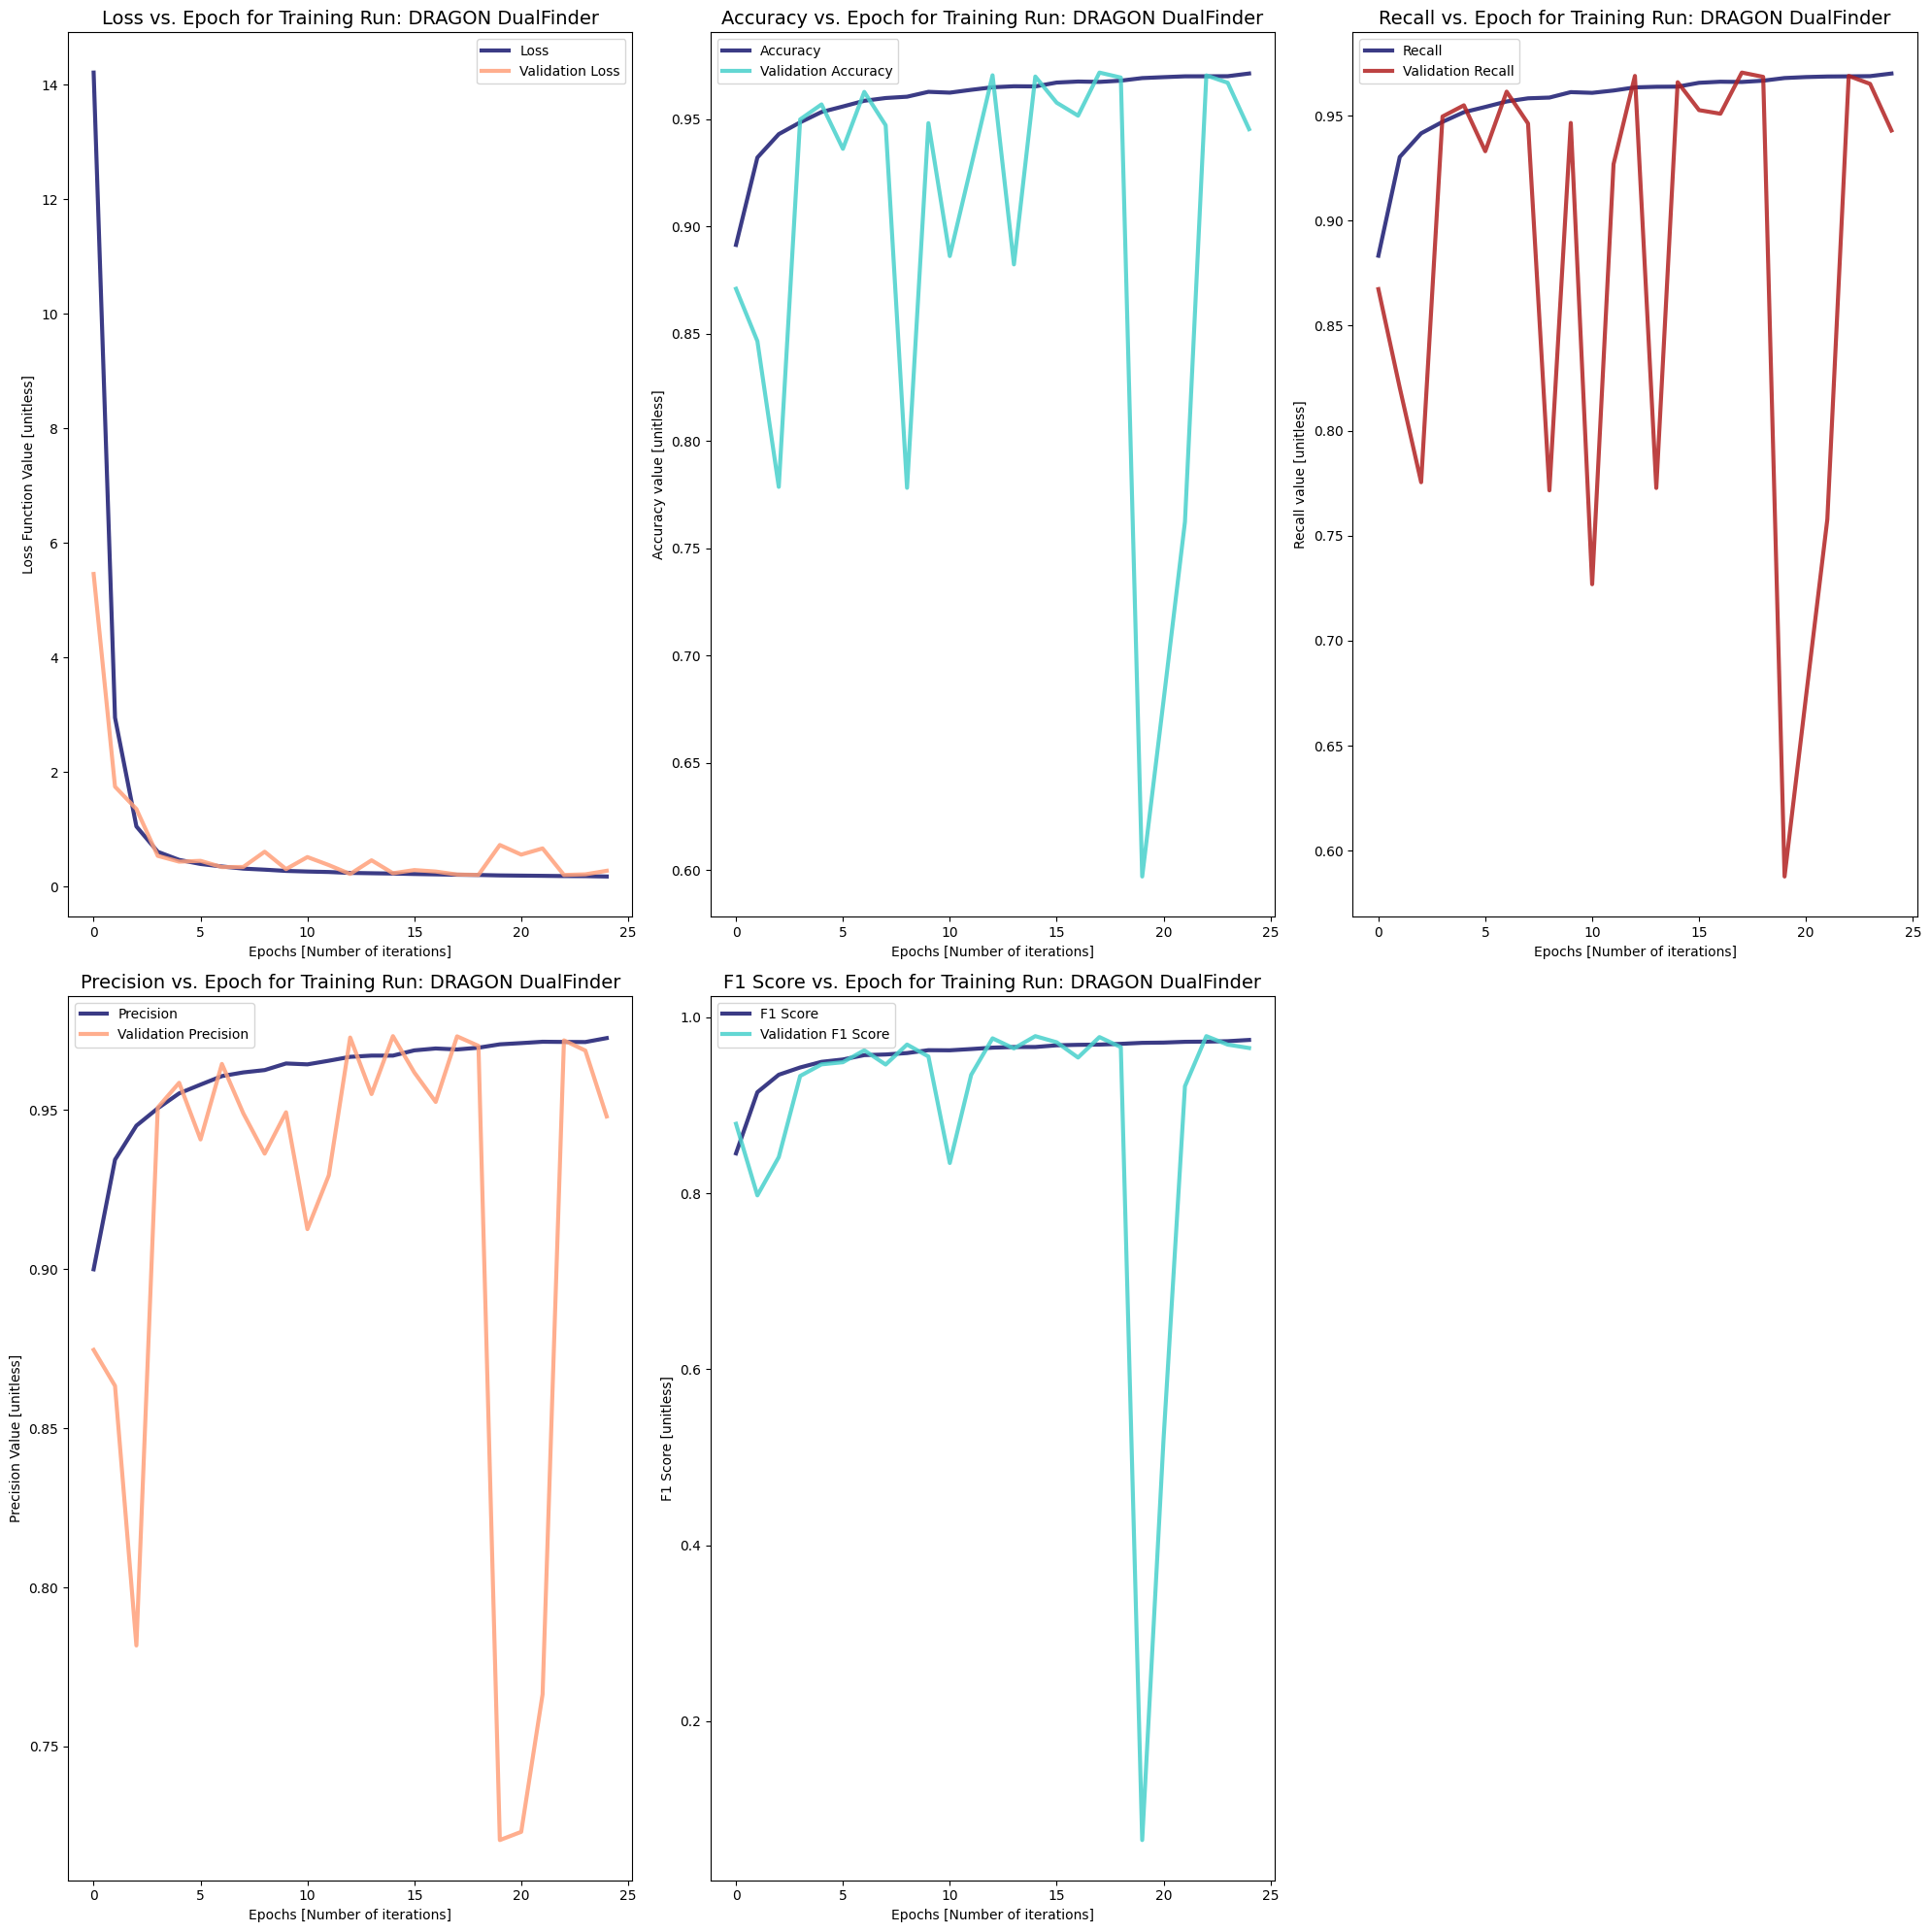

In [4]:
#print(history)
#print(type(history))
#print(history.history)
accuracy = history.history['accuracy']
loss = history.history['loss']
precision = history.history['precision']
recall = history.history['recall']
f1score = history.history['f1_score']

val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']
val_precision = history.history['val_precision']
val_recall = history.history['val_recall']
val_f1score = history.history['val_f1_score']
training_epochs = np.arange(0, epoch)
fig_save_filepath = 'DRAGON_Dual_Finder/saved_training_figures/'
if not exists(fig_save_filepath):
    os.makedirs(fig_save_filepath)
fig, ax = plot_training_progress(loss, accuracy, training_epochs, save_filepath = fig_save_filepath, training_run = "DRAGON DualFinder",
                                 recall = recall, precision = precision, f1_score = f1score,
                                 val_loss = val_loss, val_acc = val_accuracy, val_recall = val_recall, val_precision = val_precision, 
                                 val_f1_score = val_f1score)

In [5]:
eval_labels_encoded, _ = dual_finder_instance.encode_labels(test_labels, test_labels)
dual_finder_model.evaluate(test_dataset, eval_labels_encoded, batch_size = batch_size, verbose = 1)

['merger' 'empty_sky' 'dual_AGN' ... 'empty_sky' 'single_AGN' 'dual_AGN']
['merger' 'empty_sky' 'dual_AGN' ... 'empty_sky' 'single_AGN' 'dual_AGN']
Converting to list
Converting to list
424/424 [==============================] - 10s 22ms/step - loss: 0.2778 - accuracy: 0.9464 - precision: 0.9490 - recall: 0.9441 - f1_score: 0.9441


[0.27784019708633423,
 0.9464022517204285,
 0.9490495324134827,
 0.9441167712211609,
 array([0.903878  , 0.9646234 , 0.97461075, 0.93343526], dtype=float32)]

In [ ]:
len("data_preprocessing/training_datasets/")

2602it [00:04, 593.29it/s]


(2602, 94, 94, 1)
82/82 [==============================] - 1s 14ms/step


0it [00:00, ?it/s]

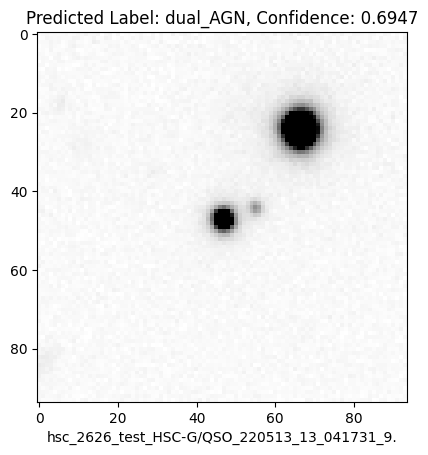

192it [00:00, 832.91it/s]

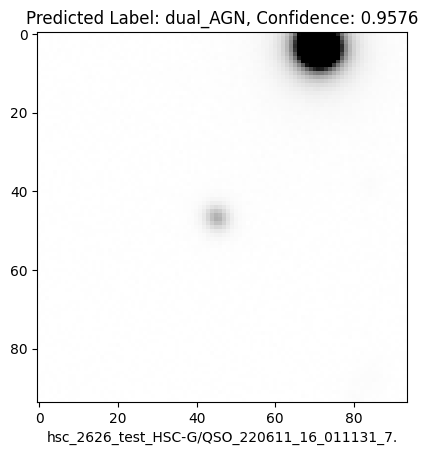

351it [00:00, 779.19it/s]

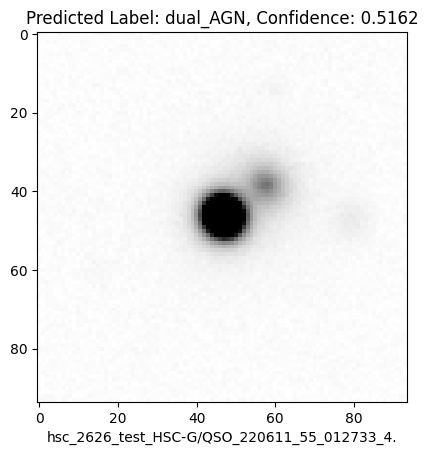

429it [00:00, 595.70it/s]

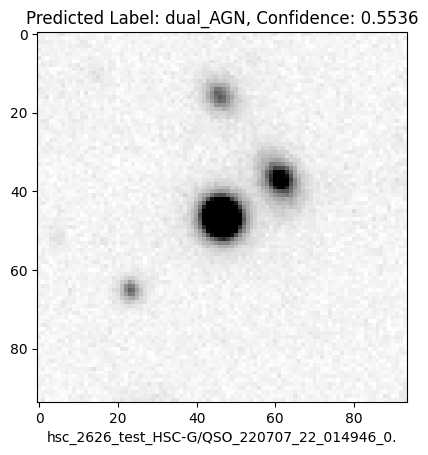

489it [00:00, 474.28it/s]

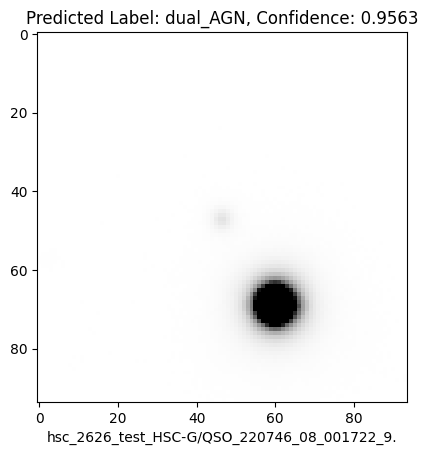

579it [00:01, 452.99it/s]

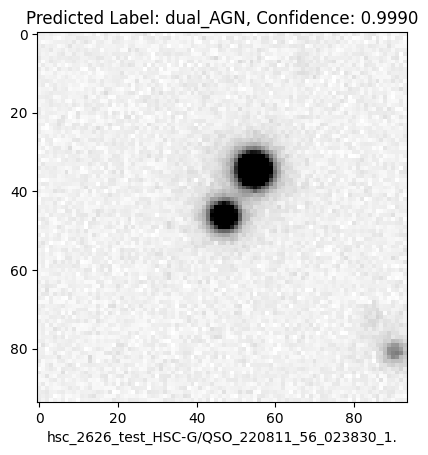

633it [00:01, 384.15it/s]

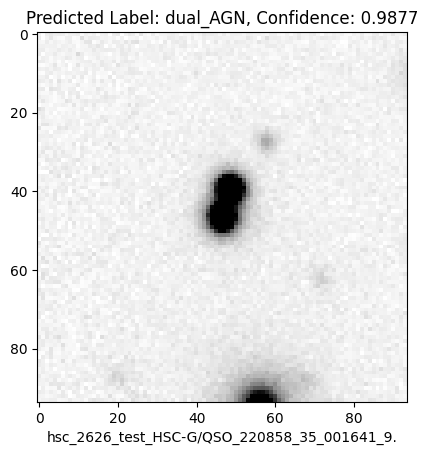

753it [00:01, 445.13it/s]

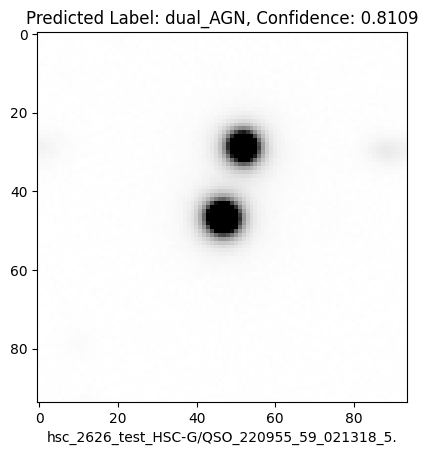

897it [00:01, 517.37it/s]

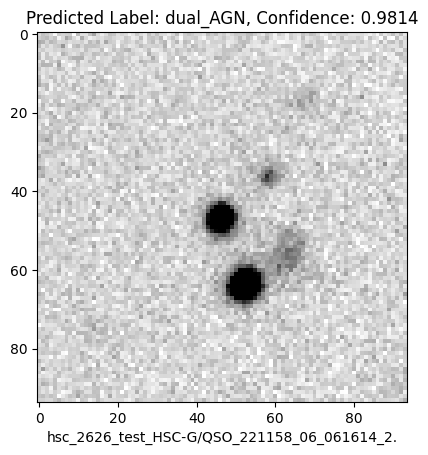

1216it [00:01, 827.39it/s]

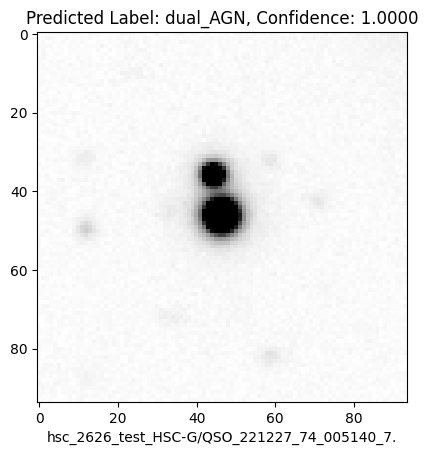

1300it [00:02, 699.90it/s]

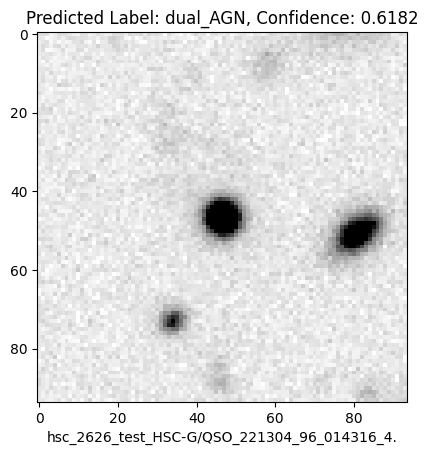

1374it [00:02, 389.79it/s]

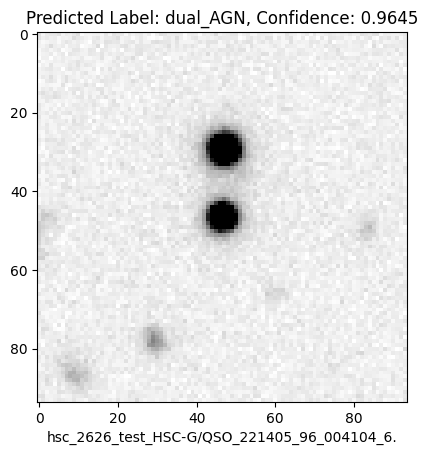

1535it [00:02, 469.91it/s]

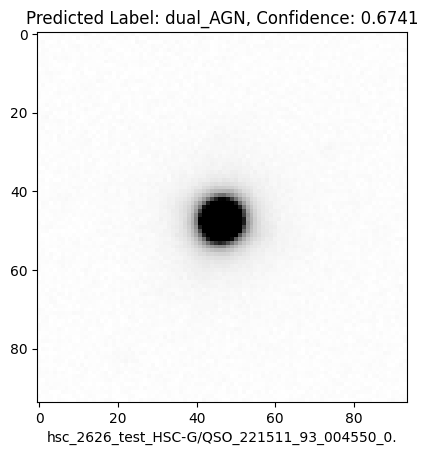

1678it [00:03, 517.93it/s]

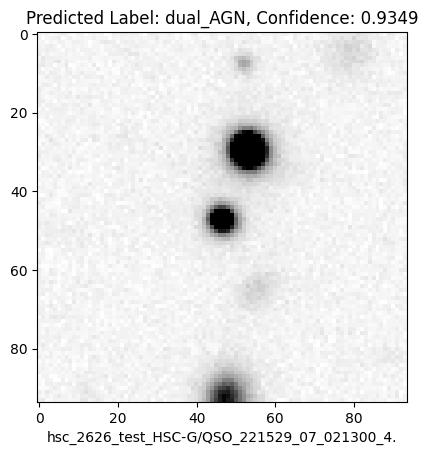

1740it [00:03, 462.86it/s]

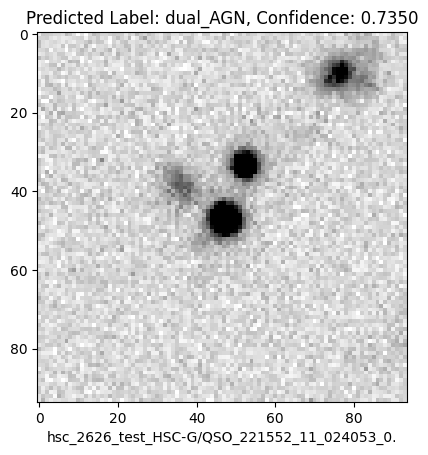

1792it [00:03, 406.33it/s]

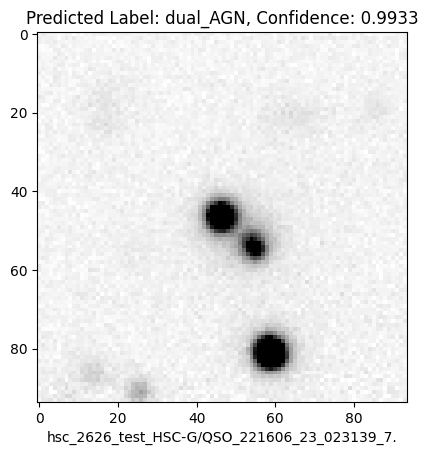

1836it [00:03, 350.85it/s]

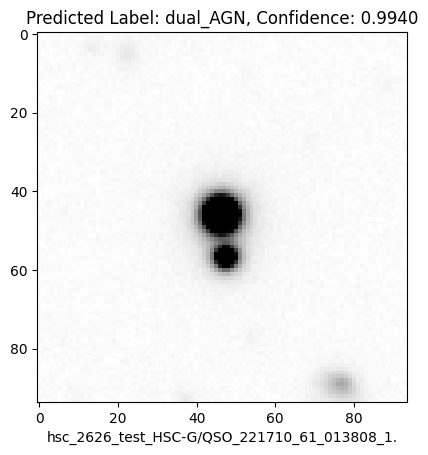

1976it [00:03, 439.92it/s]

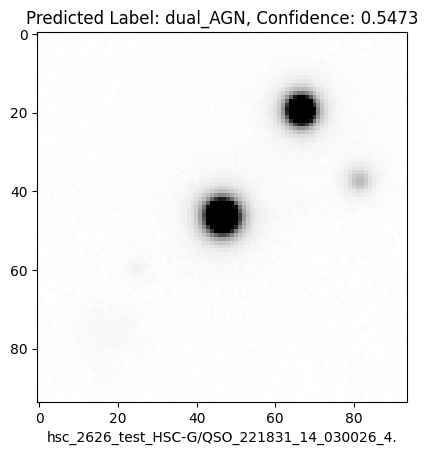

2171it [00:04, 578.91it/s]

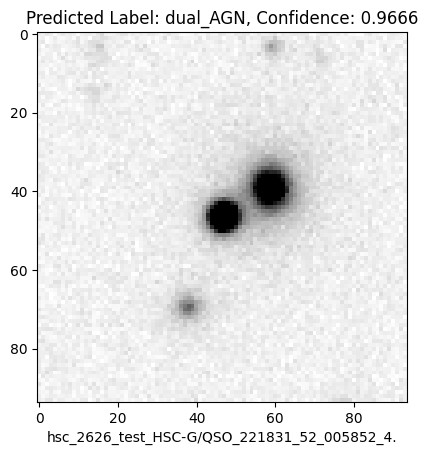

2231it [00:04, 495.02it/s]

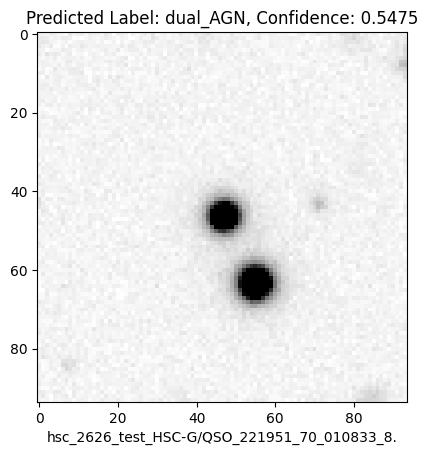

2356it [00:04, 524.83it/s]

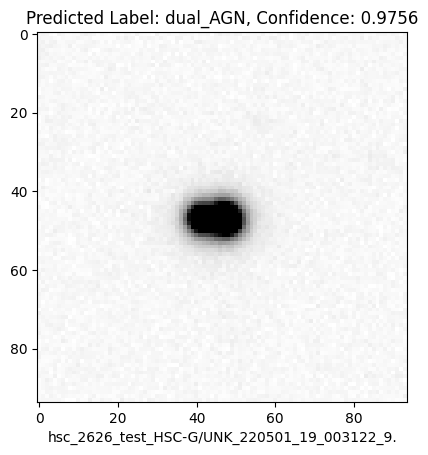

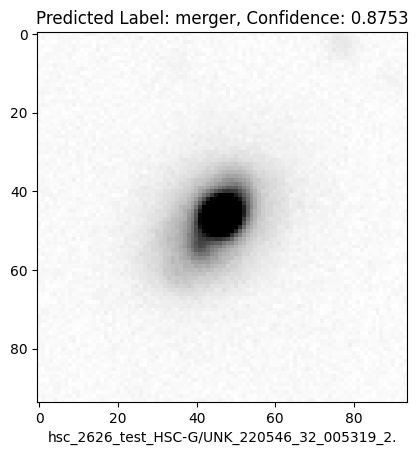

2410it [00:05, 346.28it/s]

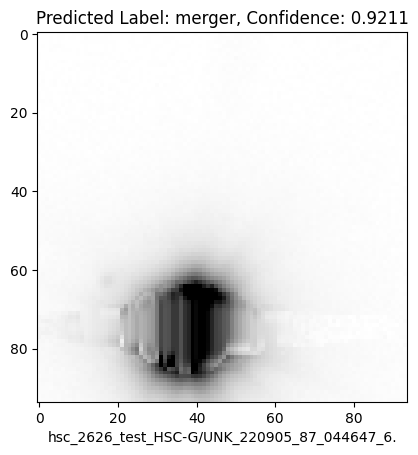

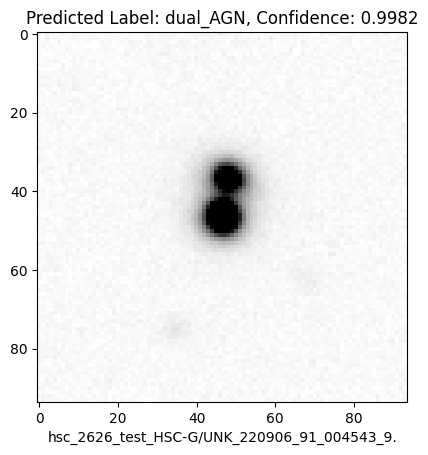

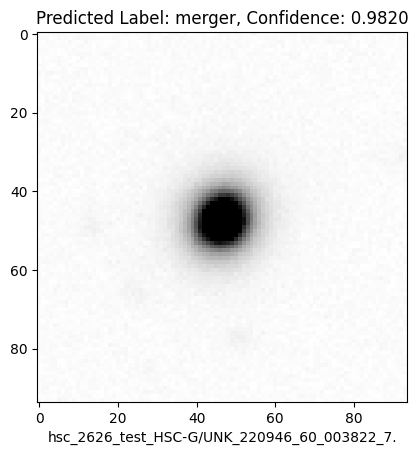

2452it [00:05, 205.98it/s]

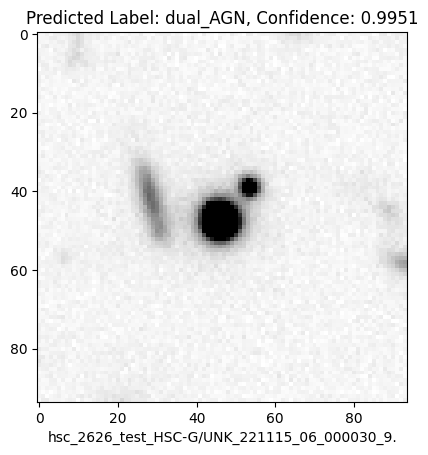

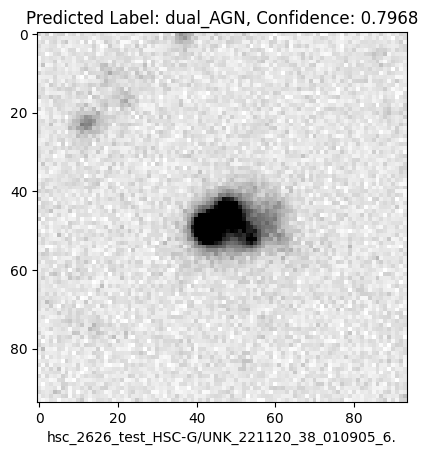

2483it [00:06, 163.07it/s]

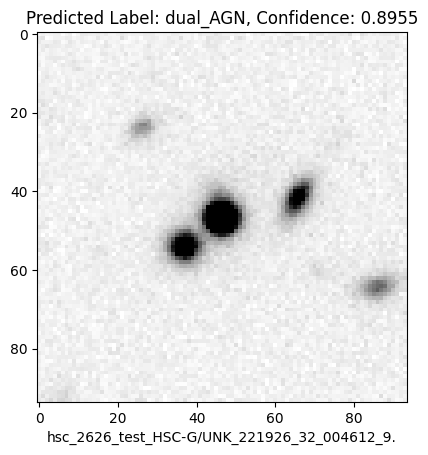

2592it [00:06, 229.39it/s]

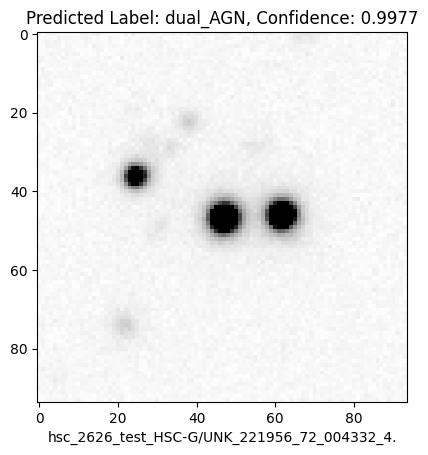

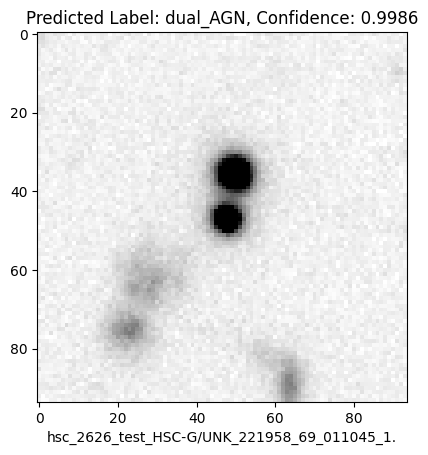

2602it [00:06, 387.27it/s]

object_ID     hsc_2626_test_HSC-G/QSO_220811_56_023830_1.fits
label                                                dual_AGN
confidence                                           0.999025
Name: 632, dtype: object
object_ID     hsc_2626_test_HSC-G/UNK_220718_43_001723_1.fits
label                                              single_AGN
confidence                                           0.465426
Name: 2413, dtype: object
object_ID     hsc_2626_test_HSC-G/UNK_220906_91_004543_9.fits
label                                                dual_AGN
confidence                                           0.998178
Name: 2439, dtype: object
object_ID     hsc_2626_test_HSC-G/UNK_221115_06_000030_9.fits
label                                                dual_AGN
confidence                                           0.995127
Name: 2478, dtype: object
Number of dual AGN:  27
Number of single AGN:  2572
Number of megers:  3
Number of empty space:  0


[{'label': 'single_AGN', 'confidence': 0.9935662},
 {'label': 'single_AGN', 'confidence': 0.99879813},
 {'label': 'single_AGN', 'confidence': 0.98160446},
 {'label': 'single_AGN', 'confidence': 0.9986333},
 {'label': 'single_AGN', 'confidence': 0.9985474},
 {'label': 'single_AGN', 'confidence': 0.97539914},
 {'label': 'single_AGN', 'confidence': 0.9300159},
 {'label': 'single_AGN', 'confidence': 0.9991602},
 {'label': 'single_AGN', 'confidence': 0.99900025},
 {'label': 'single_AGN', 'confidence': 0.9986916},
 {'label': 'single_AGN', 'confidence': 0.99392635},
 {'label': 'single_AGN', 'confidence': 0.999273},
 {'label': 'single_AGN', 'confidence': 0.9921206},
 {'label': 'single_AGN', 'confidence': 0.99148786},
 {'label': 'single_AGN', 'confidence': 0.99935263},
 {'label': 'single_AGN', 'confidence': 0.9989348},
 {'label': 'single_AGN', 'confidence': 0.999686},
 {'label': 'single_AGN', 'confidence': 0.99731004},
 {'label': 'single_AGN', 'confidence': 0.99178994},
 {'label': 'single_AGN',

In [6]:
test_images = []
test_image_names = []
for ii, image_file in tqdm(enumerate(glob.glob("hsc_2626_test_HSC-G/*.fits"))):
    try:
        with fits.open(image_file, memmap=False) as hdul:
            img = hdul[1].data
            img = crop_center(img, 94, 94)
            test_images.append(img)
            test_image_names.append(image_file)
    except OSError:
        print(f"file {image_file} has become corrupted.")
test_images = np.expand_dims(test_images, axis = -1)
print(test_images.shape)
test_instance = testResults(test_images, test_image_names, "hsc_2626_test_HSC-G/")
test_instance.test(dual_finder_model)

848/848 [==============================] - 9s 10ms/step
data_preprocessing/training_datasets/dual_AGN_datasets/train_data/object22512_with_AGN with predicted label: dual_AGN and confidence: 0.9998452663421631
data_preprocessing/training_datasets/merger_datasets/new_train_data/g_band_mergers/4092-cutout-HSC-G with predicted label: merger and confidence: 0.9385156631469727
data_preprocessing/training_datasets/dual_AGN_datasets/train_data/object26161_with_AG with predicted label: dual_AGN and confidence: 0.9973382353782654
data_preprocessing/training_datasets/merger_datasets/new_train_data/g_band_mergers/6888-cutout-HSC-G with predicted label: merger and confidence: 0.9968829154968262
data_preprocessing/training_datasets/empty_space_dataset/empty_space_train_data/ra_189.46813237248347_dec_-1.6 with predicted label: empty_sky and confidence: 0.5349545478820801
data_preprocessing/training_datasets/merger_datasets/new_train_data/g_band_mergers/3056-cutout-HSC-G with predicted label: merger a

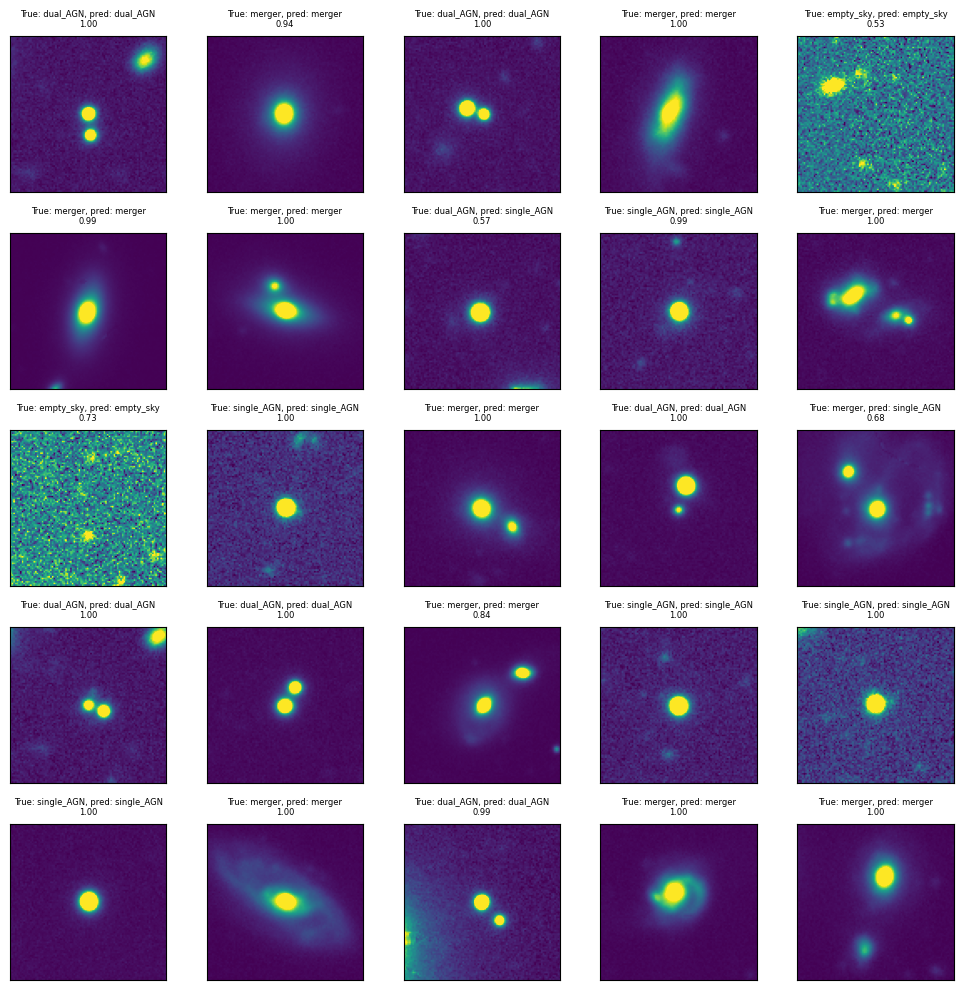

In [7]:
dual_finder_instance.predict(dual_finder_model, test_dataset, test_filepaths, test_labels)